# Phenotype Prediction

In [16]:
import pandas as pd
from sup_src import utility
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import tensorflow as tf

In [17]:
df_sra_train = pd.read_csv('data/sra_train_tissue.csv', index_col='run_accession')
df_sra_test = pd.read_csv('data/sra_test_tissue.csv', index_col='run_accession')
df_gtex = pd.read_csv('data/gtex_tissue.csv', index_col='Unnamed: 0')
df_tcga = pd.read_csv('data/tcga_tissue.csv', index_col='bigwig_file')
df_bias_injection = pd.concat([df_sra_train,df_sra_test])

# MLP



In [59]:
df_train, df_test, tissue_mapping = utility.class_to_int(pd.concat([df_gtex, df_bias_injection]), df_tcga)

train = df_train.sample(frac=1).values.astype('float32')
test = df_test.sample(frac=1).values.astype('float32')
class_weights = utility.get_class_weights(df_train)
assert len(class_weights) == 16

In [62]:
utility.run_experiment(train, test, mapping=tissue_mapping, class_weights=class_weights, model_type='mlp', 
                       pheno_type='tissue', name='mlp_gtex_sra_tcga_tissue', save=True, seeds=3)

[0.8307, 0.8602, 0.8555]
[0.7669, 0.8285, 0.792]
0.8488
0.7958000000000002


# DA

<ul>
    <li>source_layers: a list of integers representing the number of nodes to be used per layer for the source and bias mapper, [512] will create one layer with 512 nodes</li>
    <li>classifier_layers: a list of integers representing the number of nodes to be used per layer for the classifier layer, [] will only create a single output layer with n=classes</li>
    <li>lr: learning rate applied in the second training cycle
    <li>classes: number of classes in the data</li>
    <li>batch_size: number of samples per batch</li>
    <li>margin: size of margin applied in triplet loss
    <li>print: True / False, if test accuracy should be printed after every epoch during the second training cycle    
</ul>

In [43]:
config = {'mapper_layers': [512],
          'classifier_layers': [],
          'lr': 0.0005,
          'classes': 16,
          'batch_size': 64,
          'margin': 5,
          'print': True}

In [4]:
df_train, df_test, df_bias, tissue_mapping = utility.class_to_int(df_gtex, df_tcga, df_bias_injection,
                                                                 da_mode=True)
train = df_train.sample(frac=1).values.astype('float32')
test = df_test.sample(frac=1).values.astype('float32')
bias = df_bias.sample(frac=1).values.astype('float32')
class_weights = utility.get_class_weights(df_train)
assert len(class_weights) == 16

In [53]:
utility.run_experiment(train, test, bias, tissue_mapping, class_weights, config, model_type='da', name='da_gtex_sra', seeds=3, mlp_epochs=10, da_epochs=10, save=True)

0.6407699443413729
0.7809601113172542
0.8188775510204082
0.8494897959183674
0.8577226345083488
0.8693181818181818
0.8679267161410018
0.8649118738404453
0.8711734693877551
0.8688543599257885
0.6665120593692022
0.7912801484230055
0.8278061224489796
0.8580705009276438
0.8554035250463822
0.8741883116883117
0.8646799628942486
0.873956400742115
0.877435064935065
0.8755797773654916
0.6865723562152134
0.8144712430426716
0.8470547309833024
0.864448051948052
0.8658395176252319
0.8719851576994434
0.8781307977736549
0.875347866419295
0.8828849721706865
0.87847866419295
[0.8689, 0.8756, 0.8785]
[0.8057, 0.8194, 0.8128]
0.8743333
0.8126333333333333


# Box Plot

In [5]:
plot_this = ['mlp_gtex_sra_tcga_tissue','da_gtex_sra']

res_sample = {}
res_tissue = {}
res_tcga = pd.DataFrame()

for each in plot_this:
    sample = []
    tissue = []
    sample_, tissue_, _ = utility.load_and_predict(each, test, tissue_mapping, 'models/', seeds=3, classes=16)
    sample.append(sample_)
    tissue.append(tissue_)
        
    res_sample[each] = sample[0]
    res_tissue[each] = tissue[0]
    
    for i in range(len(sample[0])):
        tmp_dic = {'accuracy': float(sample[0][i]),
                  'type': 'sample',
                  'model': each}
        res_tcga = res_tcga.append(tmp_dic, ignore_index=True)
        
        tmp_dic = {'accuracy': float(tissue[0][i]),
          'type': 'class',
          'model': each}
        res_tcga = res_tcga.append(tmp_dic, ignore_index=True)

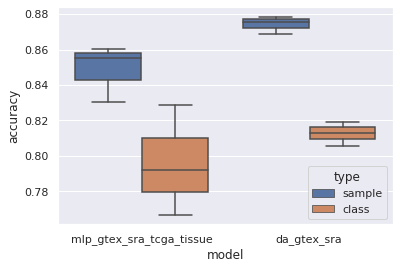

In [6]:
ax = sns.boxplot(x='model', y='accuracy', hue='type', data=res_tcga)

# Per Class Accuracy

In [9]:
list_models = []
for i in range(3):
    list_models.append(tf.keras.models.load_model('models/mlp_gtex_sra_tcga_tissue_'+str(i)+'.h5', 
                                               compile=False))

res_mlp = utility.mlp_report_per_class(test, list_models[0], 16, tissue_mapping)
res_mlp['run'] = 0

for i in range(1,3):
    df_tmp = utility.mlp_report_per_class(test, list_models[i], 16, tissue_mapping)
    df_tmp['run'] = i
    res_mlp = pd.concat([res_mlp, df_tmp])

res_mlp['data'] = 'MLP G+S-T'

In [11]:
list_models = []
for i in range(3):
    list_models.append(tf.keras.models.load_model('models/da_gtex_sra_'+str(i)+'.h5', 
                                               compile=False))

res_da = utility.mlp_report_per_class(test, list_models[0], 16, tissue_mapping)
res_da['run'] = 0

for i in range(1,3):
    df_tmp = utility.mlp_report_per_class(test, list_models[i], 16, tissue_mapping)
    df_tmp['run'] = i
    res_da = pd.concat([res_da, df_tmp])

res_da['data'] = 'DA G+S-T'

In [12]:
res = pd.concat([res_mlp, res_da])

[Text(0, 0, 'OVARY'),
 Text(0, 0, 'BRAIN'),
 Text(0, 0, 'ESOPHAGUS'),
 Text(0, 0, 'PANCREAS'),
 Text(0, 0, 'THYROID'),
 Text(0, 0, 'STOMACH'),
 Text(0, 0, 'BREAST'),
 Text(0, 0, 'SKIN'),
 Text(0, 0, 'LUNG'),
 Text(0, 0, 'TESTIS'),
 Text(0, 0, 'BONE MARROW'),
 Text(0, 0, 'ADRENAL GLAND'),
 Text(0, 0, 'UTERUS'),
 Text(0, 0, 'PROSTATE'),
 Text(0, 0, 'LIVER'),
 Text(0, 0, 'KIDNEY')]

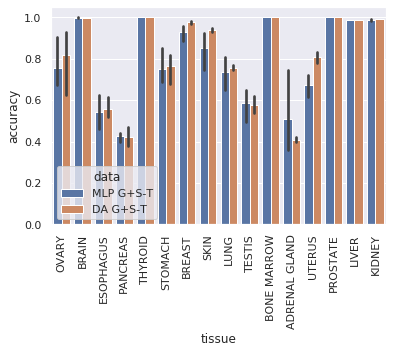

In [15]:
ax = sns.barplot(x='tissue', y='accuracy', hue='data', data=res)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)